[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nahuelalmeira/graphMachineLearning/blob/main/notebooks/Notebook2_Deteccion_De_Comunidades.ipynb)

<img src="./figuras/cropped-Logos-diplomatura-hd-2.png" width="750"/>

# Detección de comunidades

En esta notebook vamos a recorrer distintos algoritmos de detección de comunidades y algunas de las métricas con las que se pueden evaluar.

Vamos a estudiar uno de los grafos más famosos: la red de Karate de Zachary.

#### <u> Referencias </u>


- [Fortunato (2008)](https://arxiv.org/abs/0906.0612). Review de detección de comunidades
- [Newman (2018)](https://www.amazon.com/Networks-Introduction-Mark-Newman/dp/0199206651). Libro de redes complejas
- [Menczer (2019)](https://www.amazon.com/First-Course-Network-Science/dp/1108471137). Libro de redes complejas con código en Python

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

In [2]:
def plot_graph(g, comms, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12,12))
        
    colors = np.zeros(g.number_of_nodes(), dtype='int')
    for comm, node in enumerate(comms):
        colors[node] = comm

    pos = nx.spring_layout(g, seed=22)
    nx.draw(
        g, with_labels=True, pos=pos, node_color=colors, cmap='Set2', 
        ax=ax
    )
    return ax

def plot_graph_by_parameters(comms_dict, parameter_name):
    ncols = len(comms_dict)
    fig, axes = plt.subplots(figsize=(8*ncols, 10), ncols=ncols)
    for i, (param, comms) in enumerate(comms_dict.items()):
        ax = axes[i]
        comms = comms_dict[param]
        Q = evaluation.newman_girvan_modularity(g, comms).score
        ax.set_title(f'{parameter_name}: {param:.3f}\nQ = {Q:.3f}')
        plot_graph(g, comms.communities, ax=ax)
    fig.suptitle(f'Algoritmo de {comms.method_name}', fontsize=28)
    return fig, axes 

def create_contingency_table(comms1, comms2):
    """
    Compute contingency table between partition comms1 and
    partition comms2.
    
    The contingency table is defined by
    
    n_{kk'} = |C_k \cap C'_{k'}|.
    """
    table = np.zeros((len(comms1), len(comms2)))
    for i, c1 in enumerate(comms1):
        for j, c2 in enumerate(comms2):
            table[i,j] = len(set(c1).intersection(c2))
    return table

def get_all_node_properties(g):
    """
    Return a set of all node properties of the graph.
    """
    node_props = set()
    for v in g.nodes():
        node_props = node_props.union(set(g.nodes[v].keys()))
    return node_props

def get_membership(comms):
    """
    Devuelve un vector de N elementos, donde el i-ésimo elemento
    corresponde a la etiqueta de la comunidad correspondiente
    al nodo i.
    """
    if isinstance(comms, NodeClustering):
        comms = comms.communities
    N = sum(len(c) for c in comms)
    membership = np.zeros(N, dtype='int')
    for c, nodes in enumerate(comms):
        membership[list(nodes)] = c
    return membership

def get_comparison_matrix(comms1, comms2):
    """
    Construye la matriz de comparación entre particiones. 
    La matriz de comparación es una matriz de 2x2 cuyos 
    elementos están definidos de la siguiente manera:
    
    M_{11}: # pares de nodos que están en la misma comunidad en 'comms1' y 'comms2'
    M_{00}: # pares de nodos que están en distintas comunidades en 'comms1' y 'comms2'
    M_{10}: # pares de nodos que están en la misma comunidad en 'comms1' pero no en 'comms2' 
    M_{01}: # pares de nodos que están en la misma comunidad en 'comms2' pero no en 'comms1'
    """
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    membership1 = get_membership(comms1)
    membership2 = get_membership(comms2)
    N = len(membership1)
    M = np.zeros((2,2), dtype='int')
    for i in range(N):
        for j in range(i+1, N):
            if membership1[i] == membership1[j]:
                if membership2[i] == membership2[j]:
                    M[1,1] += 1
                else:
                    M[1,0] += 1
            else:
                if membership2[i] == membership2[j]:
                    M[0,1] += 1
                else:
                    M[0,0] += 1
    return M

def rand_index(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    M = get_comparison_matrix(comms1, comms2)
    return (M[0,0] + M[1,1]) / M.sum()

def jaccard_index(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    M = get_comparison_matrix(comms1, comms2)
    return M[0,0] / (M[1,1] + M[1,0] + M[0,1])

def mutual_information(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    table = create_contingency_table(comms1, comms2)
    table = table / table.sum()
    MI = 0
    for k1, comm1 in enumerate(comms1):
        for k2, comm2 in enumerate(comms2):
            if table[k1, k2] == 0:
                continue
            pk1 = table.sum(axis=1)[k1]
            pk2 = table.sum(axis=0)[k2]
            if (pk1 == 0) or (pk2 == 0):
                continue
            MI += table[k1, k2] * np.log2(table[k1, k2] / (pk1*pk2))
    return MI

def run_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = {}
    if logspace:
        resolutions = np.logspace(np.log10(min_res), np.log10(max_res), samples)
    else:
        resolutions = np.linspace(min_res, max_res, samples)
    for resolution in resolutions:
        comms = algorithms.louvain(
            g, weight='weight', resolution=resolution, randomize=False
        )
        comms_dict[resolution] = comms
    return comms_dict

def plot_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = run_louvain(g, 0.01, 10, samples=200)
    resolutions = comms_dict.keys()
    Q_values = [evaluation.newman_girvan_modularity(g, comms).score for comms in comms_dict.values()]
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel('Q')
    ax.set_xlabel('Resolution')
    ax.set_xscale('log')
    ax.plot(resolutions, Q_values, '-', label='Louvain')
    ax.legend()
    return ax

In [3]:
import networkx as nx
g = nx.karate_club_graph()
print(nx.info(g))

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


/tmp/ipykernel_7888/2909385981.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


NetworkX permite almacenar propiedades, o *features* de los nodos, enlaces y del grafo en su totalidad. Veamos qué propiedades tienen en este caso los nodos.

In [4]:
get_all_node_properties(g)

{'club'}

La única propiedad corresponde al club al cual se unieron los participantes después de la división inicial. Esta etiqueta será nuestra clasificación "real", o *ground truth*, que buscaremos obtener mediante los distintos algoritmos de detección de comunidades.

In [5]:
membership = np.array([g.nodes[v]['club'] for v in g])
set(membership)

{'Mr. Hi', 'Officer'}

In [6]:
original_comms = [
    np.array(g.nodes())[membership=='Mr. Hi'].tolist(),
    np.array(g.nodes())[membership=='Officer'].tolist()
]
original_comms

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

Visualizamos la red

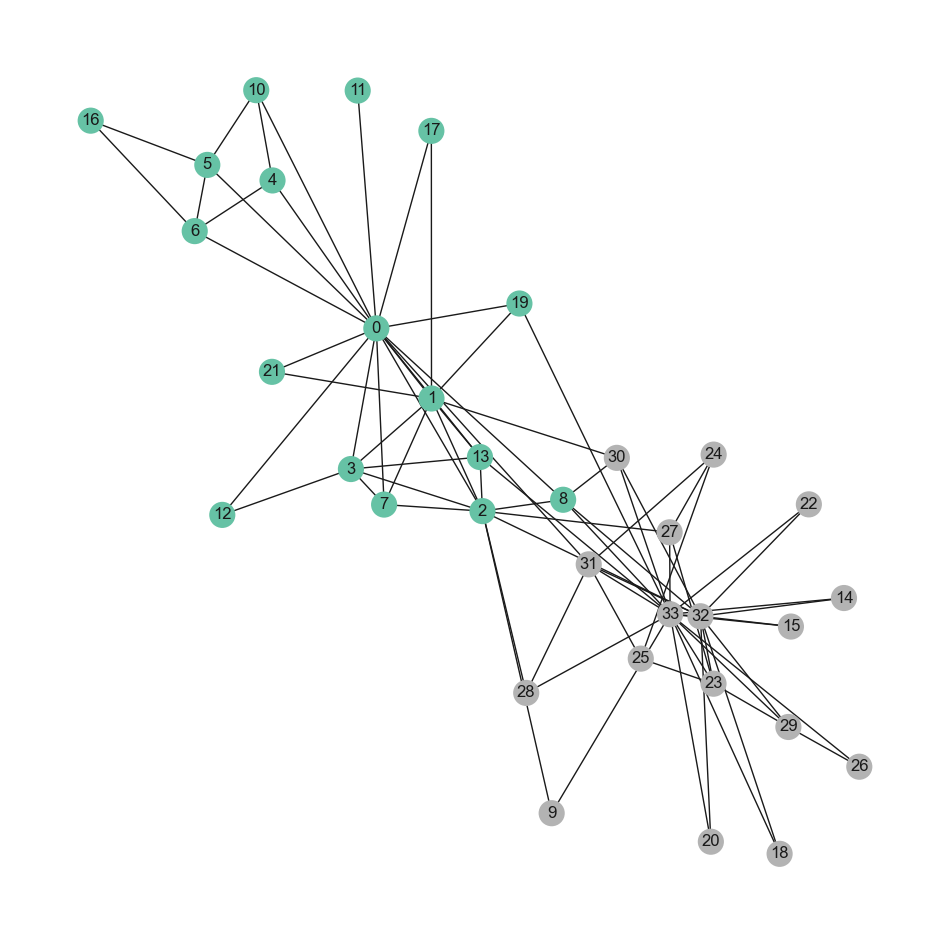

In [7]:
plot_graph(g, original_comms);

Utilizaremos la librería [cdlib](https://cdlib.readthedocs.io/en/latest/overview.html), especializada en detección de comunidades.

 Si bien no tiene implementaciones propias, agrupa las implementaciones de otras librerías (por ejemplo igraph, NetworkX, graph-tool) en una interfaz común.

In [8]:
from cdlib import NodeClustering, evaluation, algorithms

## Construimos nuestro ground truth
ground_truth = NodeClustering(original_comms, graph=g, method_name='ground')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'wurlitzer', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


#### Primer algoritmo: Propagación de etiquetas

Comenzamos aplicando el algoritmo de propagación de etiquetas, o *label propagation*. Inicialmente, suponemos que cada nodo constituye una comunidad. Luego, actualizamos iterativamente la pertenencia de cada nodo asignandole la comunidad más frecuente entre sus vecinos. En caso de que haya empates, elegimos aleatoriamente entre las más populares.

<img src="./figuras/label_propagation.jpg" width="750"/>

[Referencia](https://www.researchgate.net/publication/353777352_Weakly-supervised_learning_for_community_detection_based_on_graph_convolution_in_attributed_networks)

In [9]:
comms = algorithms.label_propagation(g)

In [10]:
comms.method_name

'Label Propagation'

In [11]:
comms.method_parameters

{'': ''}

In [12]:
comms.communities

[[32, 33, 2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30],
 [0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31],
 [16, 5, 6]]

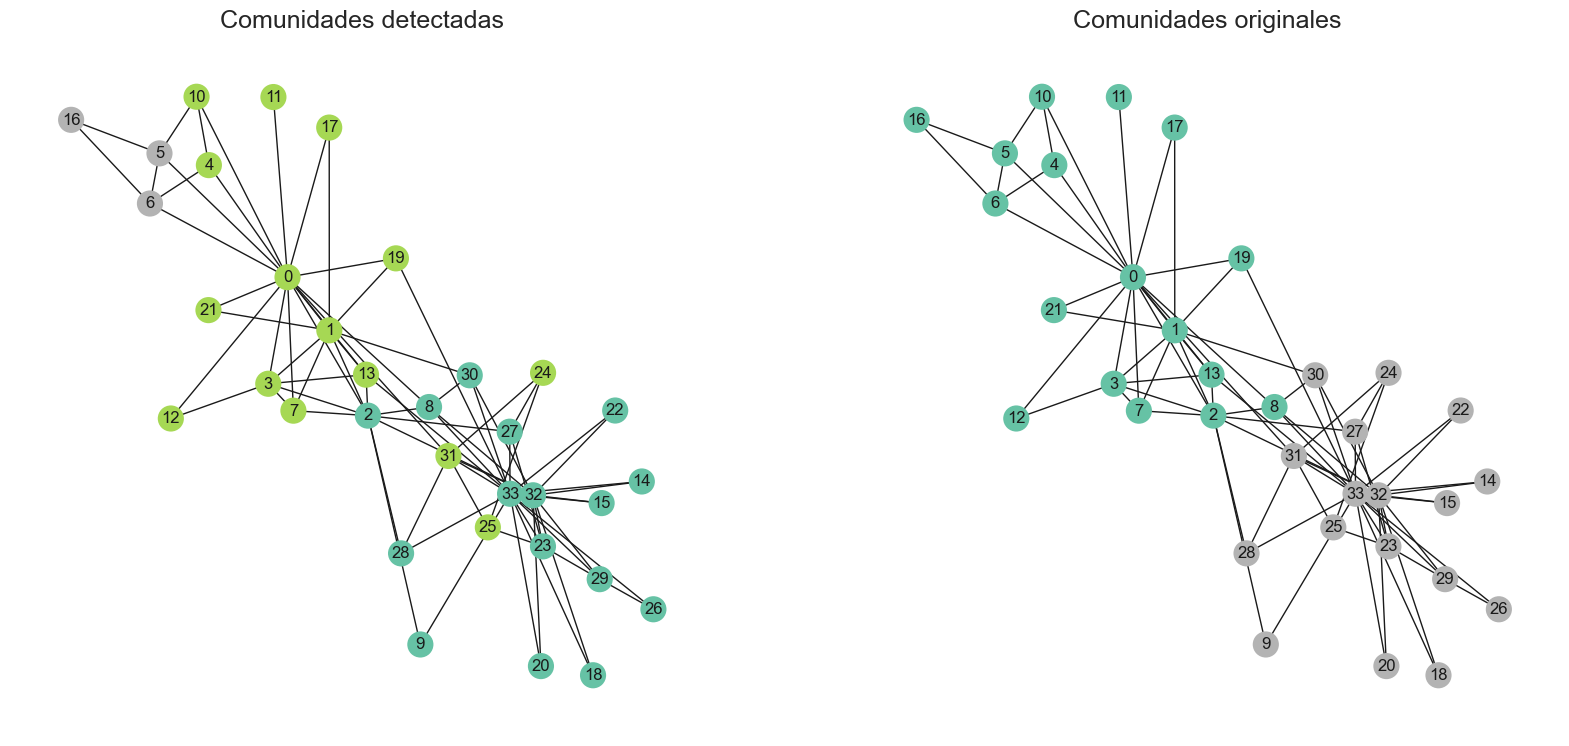

In [13]:
plt.figure(figsize=(20, 20))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax1.set_title('Comunidades detectadas')
plot_graph(g, comms.communities, ax=ax1)
ax2.set_title('Comunidades originales')
plot_graph(g, ground_truth.communities, ax=ax2)
plt.show()

## Evaluación de las comunidades encontradas

### Evaluación externa

Comparamos las comunidades halladas con las comunidades originales, o *ground truth*.

Comencemos con algunas definiciones:

Una **partición** $\mathcal{C}$ de un grafo $\mathcal{G}(V,E)$ es una división de los vértices de $\mathcal{G}$ en conjuntos mutuamente disjuntos

$$
\mathcal{C} = \left\lbrace C_1, C_2, \cdots C_K \right\rbrace 
\quad \text{ tal que } \quad
C_k \cap C_l = \emptyset\quad \text{ y }\quad \bigcup\limits_{i=1}^{K} C_k = V
$$

Supongamos ahora que tenemos dos particiones distintas $\mathcal{C}$ y $\mathcal{C'}$. Definimos la **tabla de contingencia** como la matriz 


$$
n_{kk'} = |C_k \cap C'_{k'}|.
$$

Notar que las particiones no necesariamente tienen la misma cantidad de elementos, por lo que $n_{kk'}$ es, en general, no cuadrada.

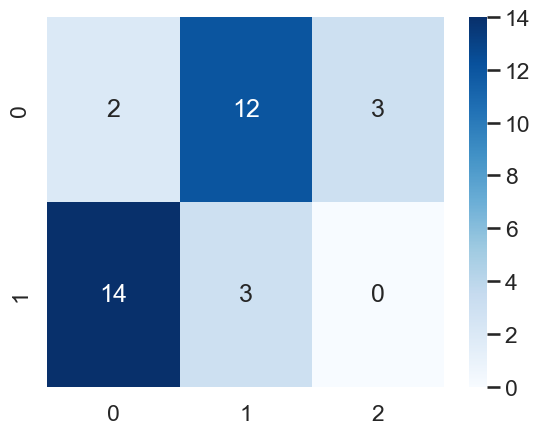

In [14]:
## Construimos y visualizamos la tabla de contingencia
table = create_contingency_table(ground_truth.communities, comms.communities)
sns.heatmap(table, annot=True, cmap='Blues');

¿Cómo cuantificamos qué tan cercana es la partición hallada a la original?

Definimos la **matriz de comparación** $M$ entre particiones como la matriz de $2\times 2$ cuyos elementos son

$$
\begin{align*}
m_{11} &\equiv \text{pares de nodos que están en la misma comunidad bajo } \mathcal{C} \text{ y bajo } \mathcal{C'} \\
m_{00} &\equiv \text{pares de nodos que están en distintas comunidades bajo } \mathcal{C} \text{ y bajo } \mathcal{C'} \\
m_{10} &\equiv \text{pares de nodos que están en la misma comunidad bajo } \mathcal{C} \text{ pero no bajo } \mathcal{C'} \\
m_{01} &\equiv \text{pares de nodos que están en la misma comunidad bajo } \mathcal{C'} \text{ pero no bajo } \mathcal{C}
\end{align*}
$$

In [15]:
## Ejemplo
comms1 = [{0, 1, 2}, {3, 4, 5}]
comms2 = [{0, 1, 3}, {2, 4, 5}]

N = sum(len(c) for c in comms1)
M = get_comparison_matrix(comms1, comms2)
print('M =\n', M)

M =
 [[5 4]
 [4 2]]


Ahora, construimos la matriz de comparación para nuestro caso de estudio.

In [16]:
print('Comunidades detectadas:')
pprint([set(comm) for comm in comms.communities])

print('Comunidades originales:')
pprint([set(comm) for comm in ground_truth.communities])

Comunidades detectadas:
[{32, 33, 2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30},
 {0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31},
 {16, 5, 6}]
Comunidades originales:
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {32, 33, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}]


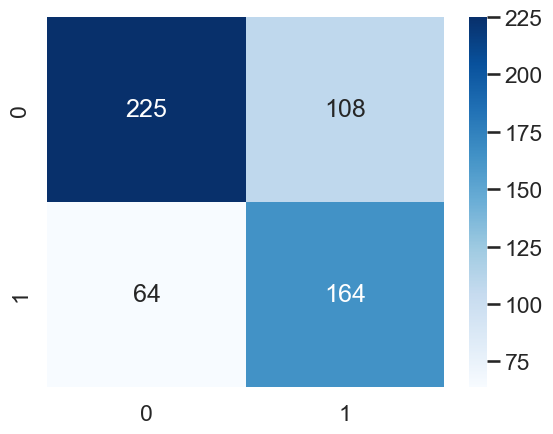

In [17]:
mat = get_comparison_matrix(comms, ground_truth)
sns.heatmap(mat, annot=True, cmap='Blues', fmt="d");

#### **Índice de Rand**

Intuitivamente, podemos ver que cuanto más diagonal sea la matriz de comparación, más cercanas son las dos particiones. Eso motiva la definición del **índice de Rand**, de la siguiente forma:

$$
\mathcal{R}(\mathcal{C}, \mathcal{C'}) = \dfrac{m_{00} + m_{11}}{m_{00} + m_{01} + m_{10} + m_{11}} = \dfrac{m_{11} + m_{00}}{N(N-1)/2}.
$$

Podemos ver fácilmente que $0 \leq \mathcal{R}(\mathcal{C}, \mathcal{C'}) \leq 1$, siendo $\mathcal{R}(\mathcal{C}, \mathcal{C'}) = 1$ el valor ideal.

In [18]:
rand_index(comms, ground_truth)

0.6934046345811051

Existe, sin embargo, un problema con el índice de Rand, y es que, en general, da valores positivos incluso cuando asignamos comunidades aleatoriamente. Es por eso que conviene normalizarlo. Una forma de hacerlo es definir el "índice de Rand ajustado" de la siguiente manera:

$$
\mathcal{AR}(\mathcal{C}, \mathcal{C'}) = \dfrac{\mathcal{R}(\mathcal{C}, \mathcal{C'})-\mathcal{E}[\mathcal{R}]}{1-\mathcal{E}[\mathcal{R}]},
$$

donde $\mathcal{E}[\mathcal{R}]$ es el valor esperado del índice de Rand bajo la hipótesis nula de particiones independientes (ver [Meila 2006]()).

In [19]:
rand_index(comms, ground_truth)

0.6934046345811051

In [20]:
evaluation.adjusted_rand_index(comms, ground_truth)

MatchingResult(score=0.3833116036505867, std=None)

#### **Índice de Jaccard**

Otra métrica que se utiliza es el **índice de Jaccard**, el cual se define de la siguiente manera:

$$
\mathcal{J}(\mathcal{C}, \mathcal{C'}) = \dfrac{m_{11}}{m_{11} + m_{10} + m_{01}}.
$$

In [21]:
jaccard_index(comms, ground_truth)

0.6696428571428571

#### **Información mutua**

La información mutua entre dos variables se puede interpretar como la cantidad de información que obtenemos sobre una variable al conocer la otra. En el contexto de particiones de grafos, se puede ver de la siguiente manera.

Definimos 

$$
p(k, k') = \dfrac{n_{kk'}}{N} = \dfrac{|C_k \cap C'_{k'}|}{N}.
$$



Con esta definición, podemos pensar en $p(k, k')$ como la probabilidad conjunta de que un nodo escogido al azar pertenezca a la comunidad $k$ en la partición $\mathcal{C}$ y a la comunidad $k'$ en la partición $\mathcal{C'}$.


Definimos a su vez las distribuciones marginales

$$
\begin{align*}
p(k) &= \sum_{k'=1}^{K'} p(k, k'), \\
p(k') &= \sum_{k=1}^{K} p(k, k').
\end{align*}
$$

La información mutua se define entonces como

$$
I(\mathcal{C}, \mathcal{C'}) = \sum_{k=1}^{K} \sum_{k'=1}^{K'}p(k, k') \log \dfrac{p(k, k')}{p(k)p(k')},
$$

con la convención de que $0/0 = 0$.

In [22]:
mutual_information(comms, original_comms)

0.425707278985177

Al igual que para los índices de Rand y de Jaccard, conviene ajustar la información mutua para corregir valores positivos espúreos (ver [Vinh 2009]()).

In [23]:
evaluation.adjusted_mutual_information(comms, ground_truth)

MatchingResult(score=0.33528605416130536, std=None)

### Evaluación interna

Es muy común que el problema de detección de comunidades se aborde como un problema de aprendizaje no supervisado. En la mayoría de los casos, no contamos con etiquetas de pertenencia a comunidades, o contamos con muy pocos ejemplos etiquetados. En estas situaciones, sólo podemos evaluar la calidad de una partición usando información estructural del grafo. 

#### **Densidad interna**

La densidad de un grafo es el cociente entre la cantidad de enlaces existentes y la cantidad de enlaces posible. Es decir,

$$
\mu = \dfrac{m}{N (N-1)/2}.
$$

La densidad interna se define como el promedio de las densidades de las comunidades, tomando únicamente los enlaces intra-comunidad.

In [24]:
m = g.number_of_edges()
N = g.number_of_nodes()
mu = m/(N*(N-1)/2)
print(f'Densidad del grafo: {mu:.2f}')
print('Comunidades originales: ', evaluation.internal_edge_density(g, ground_truth))
print('Comunidades encontradas:', evaluation.internal_edge_density(g, comms))

Densidad del grafo: 0.14
Comunidades originales:  FitnessResult(min=0.23529411764705882, max=0.25735294117647056, score=0.2463235294117647, std=0.011029411764705871)
Comunidades encontradas: FitnessResult(min=0.23809523809523808, max=1.0, score=0.5015873015873016, std=0.35262396882696795)


#### **Modularidad**

La modularidad $Q$ es la métrica más utilizada para evaluar una partición. Esta métrica se calcula como la resta entre la fracción de enlaces internos y el valor esperado de esa cantidad bajo un modelo nulo conocido como **modelo de configuración**, el cual consiste en un grafo con la misma secuencia de grado pero donde las conexiones se realizan en forma completamente aleatoria.

$$
Q = \dfrac{1}{2m} \sum_{ij} \left[ A_{ij} - \dfrac{k_i k_j}{2m} \right] \delta_{c_i, c_j}
$$

In [25]:
print('Comunidades originales: ', evaluation.newman_girvan_modularity(g, ground_truth))
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(g, comms))

Comunidades originales:  FitnessResult(min=None, max=None, score=0.39143756676224206, std=None)
Comunidades encontradas: FitnessResult(min=None, max=None, score=0.30948632896684847, std=None)


La modularidad es una buena métrica para evaluar particiones, pero no siempre es la óptima. En particular, se sabe que tiene un límite de resolución. Si un grafo presenta comunidades de tamaños muy diversos, las particiones que maximizan la modularidad son a veces aquellas en las cuales las comunidades más pequeñas se agrupan entre sí. Un ejemplo es el caso de la siguiente figura, discutido en [Fortunato and Barthélemy (2006)](https://www.pnas.org/content/104/1/36).

<img src="./figuras/modularity.png" width="250"/>

#### **Índice de corte**

Es el promedio de la fracción de enlaces entre pares de comunidades

In [26]:
print('Comunidades originales: ', evaluation.cut_ratio(g, ground_truth))
print('Comunidades encontradas:', evaluation.cut_ratio(g, comms))

Comunidades originales:  FitnessResult(min=0.03806228373702422, max=0.03806228373702422, score=0.03806228373702422, std=0.0)
Comunidades encontradas: FitnessResult(min=0.043010752688172046, max=0.06315789473684211, score=0.05159325284537508, std=0.008491042738272354)


## Algoritmos de detección de comunidades

### Algoritmo de Louvain [Blondel, et al., (2008)](https://arxiv.org/abs/0803.0476)

Este algoritmo busca una partición que maximice la modularidad. Comenzando con alguna partición inicial (por ej., una donde cada nodo constituya una comunidad), se realizan iterativamente dos pasos:

- Optimización local de la modularidad
- Agregación de comunidades



<img src="./figuras/louvain.png" width="1000"/>

[Referencia](https://arxiv.org/abs/0803.0476)

El algoritmo de Louvain es un algoritmo **jerárquico**. Después de cada iteración, obtenemos una partición cada vez menos granular. Esto lo podemos representar mediante un dendograma como el siguiente:

<img src="./figuras/dendogram2.png" width="500"/>


[Referencia](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/)

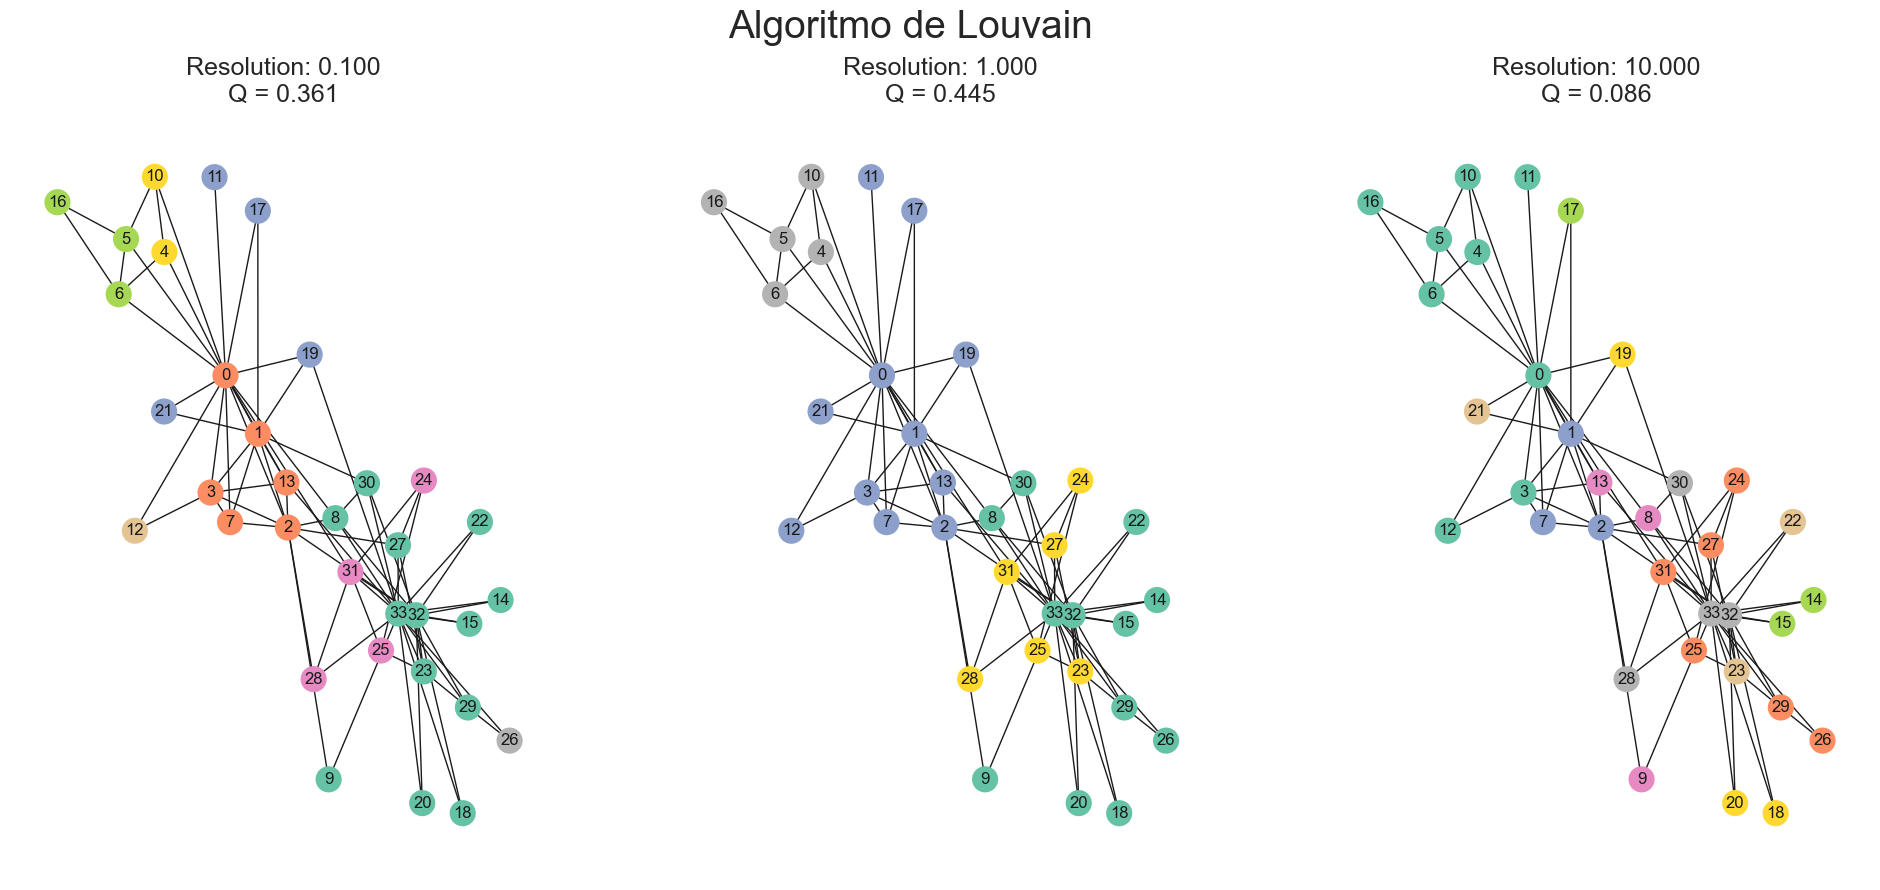

In [27]:
resolutions = [0.1, 1, 10]
comms_dict = {}
for resolution in resolutions:
    comms = algorithms.louvain(g, weight='weight', resolution=resolution, randomize=False)
    comms_dict[resolution] = comms 
plot_graph_by_parameters(comms_dict, parameter_name='Resolution');

Observamos cómo varía la modularidad en función de la resolución del algoritmo

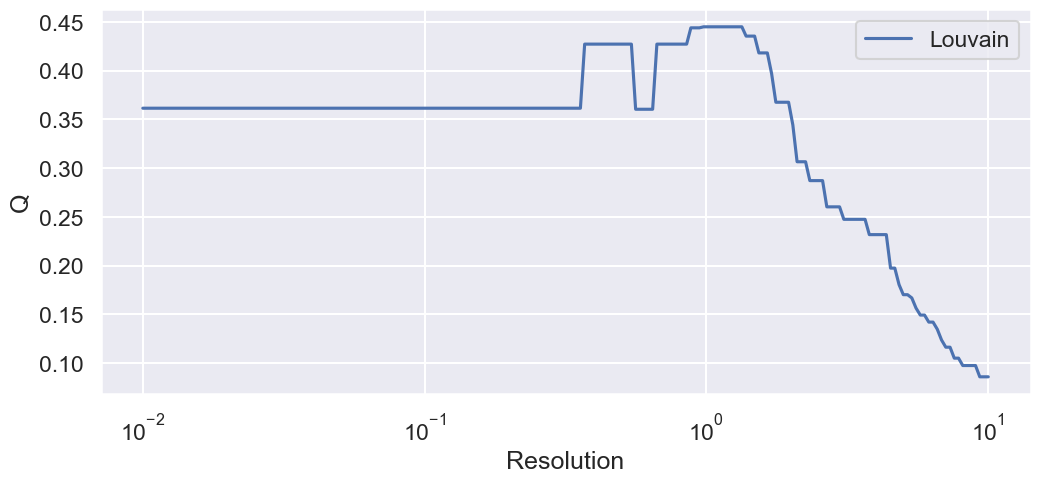

In [28]:
plot_louvain(g, min_res=0.01, max_res=10, samples=200, logspace=True);

Comparamos con otros algoritmos
- Label propagation [(Cordasco, et al. (2010)](https://arxiv.org/abs/1103.4550).
- Leiden [Traag, et al. (2019)](https://www.nature.com/articles/s41598-019-41695-z).

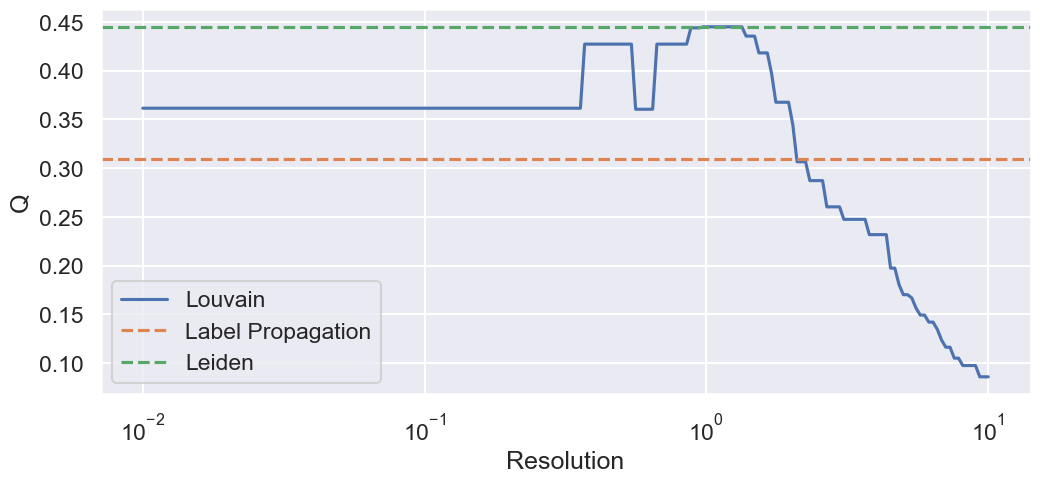

In [29]:
Q_label = evaluation.newman_girvan_modularity(g, algorithms.label_propagation(g)).score
Q_leiden = evaluation.newman_girvan_modularity(g, algorithms.leiden(g)).score
ax = plot_louvain(g, min_res=0.01, max_res=10, samples=200, logspace=True);
ax.axhline(Q_label, linestyle='--', label='Label Propagation', color='C1')
ax.axhline(Q_leiden, linestyle='--', label='Leiden', color='C2')
ax.legend();

### Algoritmo de Girvan-Newman [Girvan and Newman (2002)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/)

El algoritmo de Girvan-Newman consiste en ir "desarmando" iterativamente el grafo, **removiendo** de a uno los **enlaces**. La idea es remover, en primer lugar, los enlaces que **intermedien** entre comunidades y, de ese modo, ir separando las comunidades entre sí. En su versión original, los enlaces se remueven en orden decreciente de **betweeness**.

<img src="./figuras/two_comms.png" width="500"/>

Al igual que el algoritmo de Louvain, este algoritmo es jerárquico.

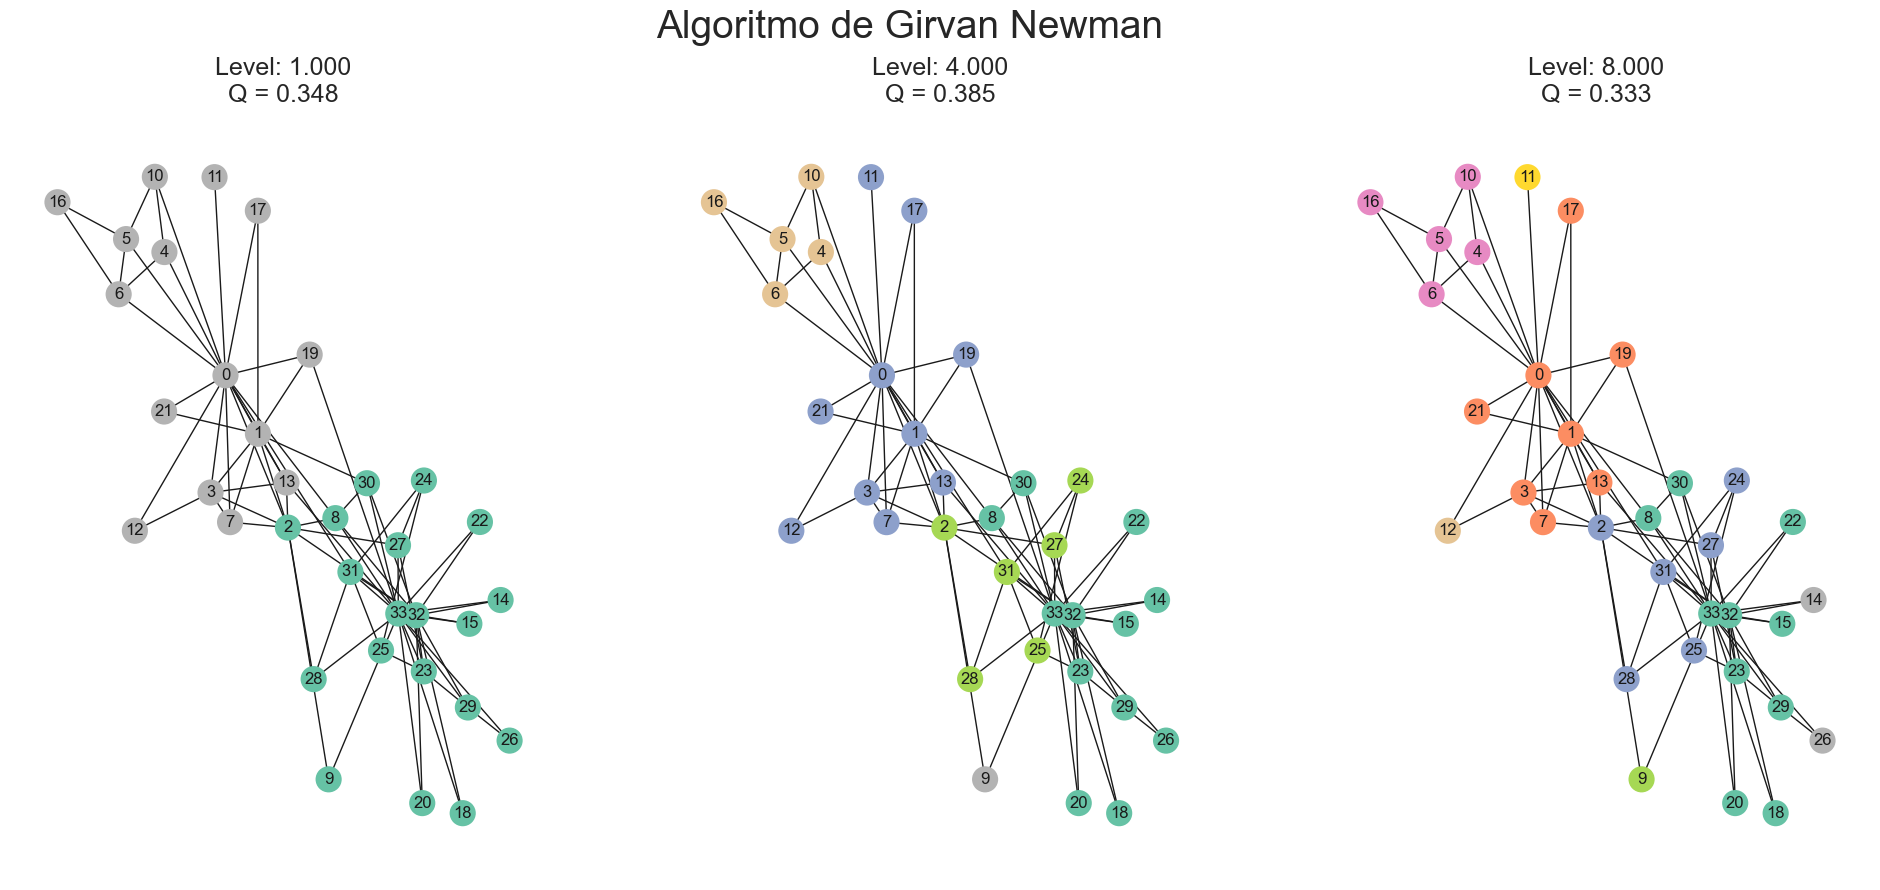

In [30]:
levels = [1, 4, 8]
comms_dict = {}
for level in levels:
    comms = algorithms.girvan_newman(g, level=level)
    comms_dict[level] = comms
plot_graph_by_parameters(comms_dict, parameter_name='Level');

In [31]:
level = 1
levels = range(1, 16)
data = []
for level in levels:
    comms = algorithms.girvan_newman(g, level=level)
    ncomms = len(comms.communities)
    Q = evaluation.newman_girvan_modularity(g, comms).score
    data.append((level, ncomms, Q))
    
df = pd.DataFrame(data, columns=['Level', 'ncomms', 'Q'])
df

,Level,ncomms,Q
0,1,2,0.347660
1,2,3,0.342319
2,3,4,0.358061
3,4,5,0.384972
4,5,6,0.375780
5,6,7,0.359476
6,7,8,0.347070
7,8,9,0.333249
8,9,10,0.313441
9,10,11,0.312260


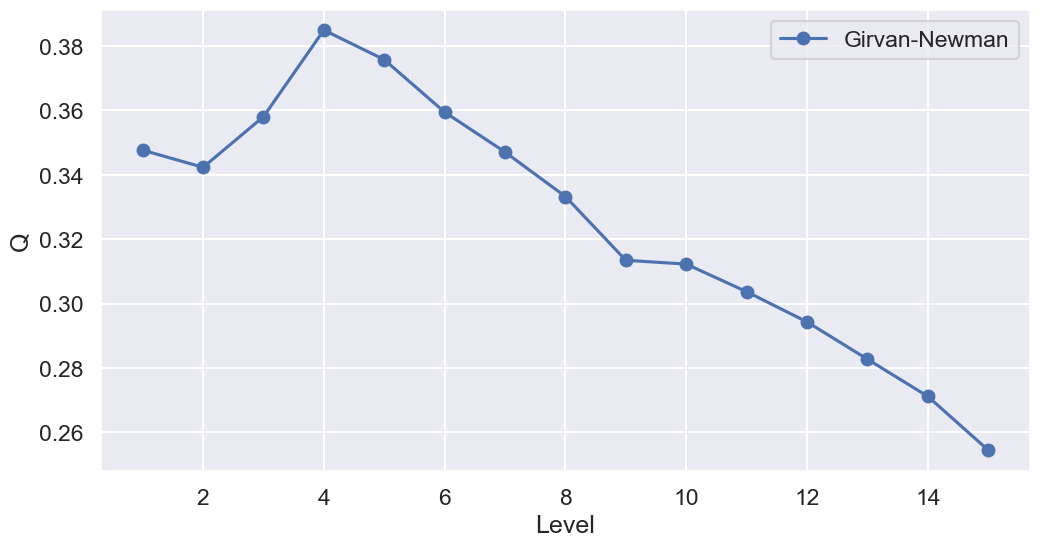

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_ylabel('Q')
ax.set_xlabel('Level')
ax.plot(df.Level, df.Q, '-o', label='Girvan-Newman')
ax.legend()
plt.show()